In [5]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional


In [6]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [7]:
# removing stopwords and saving alpha words. 
import spacy

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner","textcat"])

def preprocess(text):
    return ' '.join(tok.text for tok in nlp(text) if tok.is_alpha and not tok.is_stop).lower()

In [8]:
import pandas as pd
start = pd.read_csv('lyrics_01_09.csv', sep=',')
#start = start.set_index("index")
print("The original lyrics")
print(start.lyrics[0])

The original lyrics
It has been so long eating and drinking being merry How strange, how strange Taking our Great Mongol ancestors names in vain How strange, how strange Yet, would not honor our oath and destiny How strange, how strange Why the valuable ethics of ancestors become worthless? How strange, how strange Hey, you traitor Kneel down Hey, Prophecies be declared You've born in ancestor’s fate yet Sleeping deeply, can't be awakened How strange, how strange Blindly declaring that Only Mongols are the best How strange, how strange Born to live as nobles Yet, can't unite as one How strange, how strange Why is it difficult to rise up our nation up? How strange, how strange Hey, you traitor Kneel down Hey, Prophecies be declared Why it’s so hard to cherish the Ancestors' inherited land? How strange, how strange Why priceless edifications of elders turning to ashes? How strange, how strange With the future of eternal prosperity, The Wolf totemed Mongols have the blessings of Heaven Bo

In [9]:
lyrics = []
genre = []
for i,l in start.iterrows():
    genre.append(l.grouped_genre)
    lyric = preprocess(l.lyrics) 
    lyrics.append(lyric)

In [10]:
genre = [i if i != "go-go" else "gogo" for i in genre]  
genre = [i if i != "doo-wop" else "doowop" for i in genre] 

In [11]:
print("Removal of stopwords")
print(lyrics[0])

Removal of stopwords
long eating drinking merry strange strange taking great mongol ancestors names vain strange strange honor oath destiny strange strange valuable ethics ancestors worthless strange strange hey traitor kneel hey prophecies declared born ancestor fate sleeping deeply awakened strange strange blindly declaring mongols best strange strange born live nobles unite strange strange difficult rise nation strange strange hey traitor kneel hey prophecies declared hard cherish ancestors inherited land strange strange priceless edifications elders turning ashes strange strange future eternal prosperity wolf totemed mongols blessings heaven born undeniable fate gather nations lord chinggis declares earth come come oh black banner awakened awakened oh khanate royal power rise rise forever strange strange oh black banner awakened awakened oh khanate royal power rise rise forever


In [12]:
print(len(lyrics))
print(len(genre))

26912
26912


In [13]:
vocab_size = 6000 # 5000 make the top list of words (common words)
embedding_dim = 32# 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

In [14]:
#tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n-1234567890´–', 
                      lower=True, oov_token=oov_tok)
tokenizer.fit_on_texts(lyrics)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))#99530

Found 81667 unique tokens.


In [15]:

lyrics_sequences = tokenizer.texts_to_sequences(lyrics)
lyrics_padded = pad_sequences(lyrics_sequences, maxlen=max_length, 
                             padding=padding_type, truncating=trunc_type).astype(np.float32)
print('Shape of data tensor:', lyrics_padded.shape)

Shape of data tensor: (26912, 200)


In [16]:
import pandas as pd
genre_names = pd.get_dummies(genre)
genre_seq = genre_names.values
print('Shape of label tensor:', genre_seq.shape)

Shape of label tensor: (26912, 20)


In [17]:
labels = list(genre_names.columns)
print(labels)

['alternativeamericana', 'blues', 'bmore', 'chill', 'country', 'doowop', 'folk', 'gogo', 'hardglam', 'hiphop', 'house', 'indie', 'metal', 'nuelectro', 'pop', 'punk', 'rap', 'rave', 'rock', 'worship']


In [18]:
from sklearn.model_selection import train_test_split
# Train and test_valedation split
X_train,X_val_test,Y_train,Y_val_test = train_test_split(lyrics_padded,
                                                 genre_seq,
                                                 test_size=0.15,
                                                 random_state= 54321)
# Test and valedation split
X_test,X_val,Y_test,Y_val = train_test_split(X_val_test,
                                                 Y_val_test,
                                                 test_size=0.75,
                                                 random_state= 43125)


In [19]:
from tensorflow.keras import layers

model = Sequential()


model.add(Embedding(vocab_size, 64, input_length=X_train.shape[1]))

#model.add(layers.SpatialDropout1D(0.3))#.2
#model.add(layers.Dropout(.5))# 100 , dropout=0.2, recurrent_dropout=0.2
model.add(layers.Dropout(.2))# 100 , dropout=0.2, recurrent_dropout=0.2

model.add(LSTM(64, return_sequences=True))# 100 , dropout=0.2, recurrent_dropout=0.2
model.add(LSTM(32))# 100 , dropout=0.2, recurrent_dropout=0.2

model.add(layers.Dropout(.5))# 100 , dropout=0.2, recurrent_dropout=0.2

#model.add(Dense(20,activation = "tanh", 
#               kernel_regularizer = tf.keras.regularizers.L1(0.001)))# relu #tanh 
model.add(Dense(20,activation = "softmax"))# relu #tanh 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           384000    
_________________________________________________________________
dropout (Dropout)            (None, 200, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200, 64)           33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                660       
Total params: 430,100
Trainable params: 430,100
Non-trainable params: 0
__________________________________________________

In [20]:
num_epochs = 60
history = model.fit(X_train, Y_train, epochs=num_epochs, 
                    validation_data=(X_val, Y_val), verbose=2)

Epoch 1/60
715/715 - 72s - loss: 2.6079 - accuracy: 0.2028 - val_loss: 2.4919 - val_accuracy: 0.2417
Epoch 2/60
715/715 - 68s - loss: 2.5218 - accuracy: 0.2303 - val_loss: 2.4764 - val_accuracy: 0.2434
Epoch 3/60
715/715 - 68s - loss: 2.4842 - accuracy: 0.2374 - val_loss: 2.4699 - val_accuracy: 0.2424
Epoch 4/60
715/715 - 67s - loss: 2.4561 - accuracy: 0.2454 - val_loss: 2.4993 - val_accuracy: 0.2411
Epoch 5/60
715/715 - 67s - loss: 2.4321 - accuracy: 0.2552 - val_loss: 2.4928 - val_accuracy: 0.2427
Epoch 6/60
715/715 - 67s - loss: 2.3949 - accuracy: 0.2744 - val_loss: 2.4810 - val_accuracy: 0.2685
Epoch 7/60
715/715 - 67s - loss: 2.3585 - accuracy: 0.2985 - val_loss: 2.4357 - val_accuracy: 0.2999
Epoch 8/60
715/715 - 67s - loss: 2.3026 - accuracy: 0.3234 - val_loss: 2.4781 - val_accuracy: 0.3025
Epoch 9/60
715/715 - 67s - loss: 2.2491 - accuracy: 0.3414 - val_loss: 2.4038 - val_accuracy: 0.3121
Epoch 10/60
715/715 - 67s - loss: 2.1986 - accuracy: 0.3549 - val_loss: 2.4266 - val_accura

In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

accr

32/32 [==============================] - 1s 26ms/step - loss: 3.1460 - accuracy: 0.3588
Test set
  Loss: 3.146
  Accuracy: 0.359


[3.1459951400756836, 0.35877105593681335]

In [22]:
def predicted_class(m):
    p = [np.argmax(i) for i in m]
    return p

pred_list = model.predict(X_test)
pred_test = predicted_class(pred_list)
real_test = predicted_class(Y_test)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(real_test, pred_test, target_names = labels, zero_division =0))

                      precision    recall  f1-score   support

alternativeamericana       0.48      0.57      0.52        46
               blues       0.25      0.07      0.11        30
               bmore       0.21      0.23      0.22        22
               chill       0.17      0.04      0.06        26
             country       0.33      0.09      0.14        23
              doowop       0.62      0.80      0.70        25
                folk       0.07      0.05      0.06        37
                gogo       0.25      0.07      0.11        15
            hardglam       0.43      0.32      0.36        19
              hiphop       0.44      0.36      0.40        58
               house       0.10      0.17      0.13        30
               indie       0.19      0.22      0.20        92
               metal       0.68      0.56      0.61       158
           nuelectro       0.25      0.07      0.11        15
                 pop       0.36      0.44      0.40       232
       

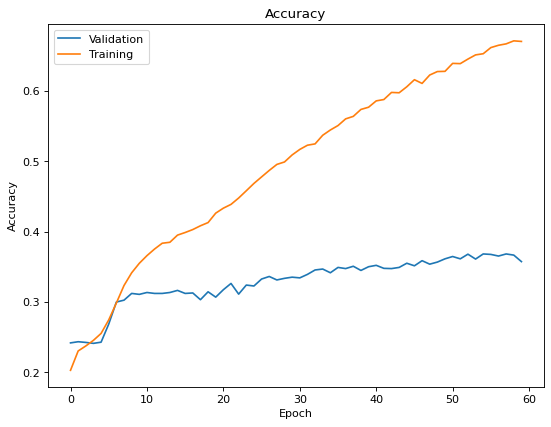

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history["val_accuracy"],label="Validation");
plt.plot(history.history["accuracy"], label="Training")
plt.legend(loc="upper left")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');
plt.savefig("images/lstm_ac.png")

In [25]:
model3 = Sequential()


model3.add(Embedding(vocab_size, 64, input_length=max_length))

#model2.add(layers.SpatialDropout1D(0.3))#.2
#model3.add(LSTM(50))# 100
#model3.add(layers.Dropout(.2))
model3.add(layers.Dropout(.2))

model3.add(layers.GRU(64, return_sequences = True))
model3.add(layers.SimpleRNN(32))

model3.add(layers.Dropout(.5))

model3.add(Dense(20,activation = "sigmoid"))# relu #tanh 

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           384000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
gru (GRU)                    (None, 200, 64)           24960     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                3104      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
Total params: 412,724
Trainable params: 412,724
Non-trainable params: 0
________________________________________________

In [26]:
num_epochs = 60
history3 = model3.fit(X_train, Y_train, epochs=num_epochs, 
                    validation_data=(X_val, Y_val), verbose=2)

Epoch 1/60
715/715 - 60s - loss: 2.6347 - accuracy: 0.1965 - val_loss: 2.5016 - val_accuracy: 0.2381
Epoch 2/60
715/715 - 59s - loss: 2.5391 - accuracy: 0.2257 - val_loss: 2.4906 - val_accuracy: 0.2391
Epoch 3/60
715/715 - 57s - loss: 2.4750 - accuracy: 0.2421 - val_loss: 2.4967 - val_accuracy: 0.2404
Epoch 4/60
715/715 - 58s - loss: 2.4249 - accuracy: 0.2477 - val_loss: 2.4842 - val_accuracy: 0.2384
Epoch 5/60
715/715 - 58s - loss: 2.3515 - accuracy: 0.3001 - val_loss: 2.4112 - val_accuracy: 0.3127
Epoch 6/60
715/715 - 56s - loss: 2.2335 - accuracy: 0.3535 - val_loss: 2.3958 - val_accuracy: 0.3207
Epoch 7/60
715/715 - 58s - loss: 2.1464 - accuracy: 0.3743 - val_loss: 2.4196 - val_accuracy: 0.3118
Epoch 8/60
715/715 - 56s - loss: 2.0923 - accuracy: 0.3854 - val_loss: 2.4276 - val_accuracy: 0.3184
Epoch 9/60
715/715 - 56s - loss: 2.0329 - accuracy: 0.3989 - val_loss: 2.4635 - val_accuracy: 0.2972
Epoch 10/60
715/715 - 55s - loss: 1.9740 - accuracy: 0.4136 - val_loss: 2.4831 - val_accura

In [29]:
accr = model3.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


32/32 [==============================] - 1s 18ms/step - loss: 3.5821 - accuracy: 0.3558
Test set
  Loss: 3.582
  Accuracy: 0.356


In [27]:
pred_list = model3.predict(X_test)
pred_test = predicted_class(pred_list)
real_test = predicted_class(Y_test)
print(classification_report(real_test, pred_test, target_names = labels, zero_division =0))

                      precision    recall  f1-score   support

alternativeamericana       0.41      0.65      0.50        46
               blues       0.11      0.07      0.08        30
               bmore       0.16      0.14      0.15        22
               chill       0.18      0.15      0.17        26
             country       0.33      0.17      0.23        23
              doowop       0.77      0.68      0.72        25
                folk       0.10      0.08      0.09        37
                gogo       0.00      0.00      0.00        15
            hardglam       0.44      0.37      0.40        19
              hiphop       0.42      0.40      0.41        58
               house       0.07      0.10      0.08        30
               indie       0.23      0.28      0.25        92
               metal       0.66      0.53      0.59       158
           nuelectro       0.09      0.07      0.08        15
                 pop       0.44      0.41      0.42       232
       

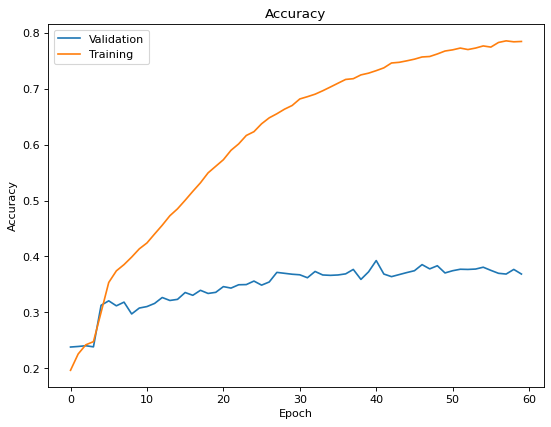

In [28]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history3.history["val_accuracy"],label="Validation");
plt.plot(history3.history["accuracy"], label="Training")
plt.legend(loc="upper left")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');
plt.savefig("images/gru_ac.png")